In [8]:
import sys
import os
import copy

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.cluster as hpacl  # Now this should work
import hpa.util as hpau  # Now this should work
import hpa.plots as hpapl

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import gsd.hoomd 
from MDAnalysis.analysis import distances



In [10]:
path_200 = '/localscratch/zippoema/project_ness/simulations/200-tdp43_CAL3/'
path = '/localscratch/zippoema/project_ness/simulations/'
path_work = '/localscratch/zippoema/working_dir/'
path_an_200 = '/localscratch/zippoema/project_ness/analysis/200-tdp43_CAL3/'
path_an_dp = '/localscratch/zippoema/project_ness/analysis/condensate_dephospho/'
path_dp = '/localscratch/zippoema/project_ness/simulations/condensate_dephospho/'
path_ness = '/localscratch/zippoema/project_ness/simulations/simple-ness_CAL3/'
path_fix = '/localscratch/zippoema/project_ness/simulations/ness_1-ck1d_1-pp3/'

### Center trajectory

In [24]:
pt='/localscratch/zippoema/working_dir/condensate_struct_CAL3/sim_eq_slab_400-tdp43-lcd_5-ck1d-open/'
hpau.center_trajectory_z(pt+'sim_eq_slab_400-tdp43-lcd_5-com-ck1d-open_CAL3_dump.gsd',
                       pt+'sim_eq_slab_400-tdp43-lcd_5-com-ck1d-open_CAL3_dump_centered.gsd',
                       group=[i for i in range(61600)], cluster=True, eps=2.0, min_samples=1)

100%|█████████████████████████████████████████| 500/500 [05:13<00:00,  1.59it/s]


In [5]:
hpau.center_trajectory('/localscratch/zippoema/project_ness/simulations/condensate_dephospho/sim_200-tdp43-lcd-2800pser_5-pp3/sim1_200-tdp43-lcd-2800pser_5-com-pp3_CAL3_10us_dump.gsd',
                       '/localscratch/zippoema/project_ness/simulations/condensate_dephospho/sim_200-tdp43-lcd-2800pser_5-pp3/sim1_200-tdp43-lcd-2800pser_5-com-pp3_CAL3_10us_dump_centered.gsd',
                      group=[i for i in range(30800)], cluster=True, eps=2.0, min_samples=1)
                       

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'wb' mode is deprecated, use 'w'
  gsdfileobj = fl.open(name=str(name),
100%|███████████████████████████████████████████████████████████████| 2500/2500 [07:50<00:00,  5.31it/s]


In [6]:
for i in range(1,11):
    hpau.center_trajectory(path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_resize_end.gsd', path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered1.gsd')
    hpau.center_trajectory(path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered1.gsd', path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered.gsd')
    hpau.center_trajectory(path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered.gsd', path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered1.gsd')
    hpau.center_trajectory(path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered1.gsd', path+f'sim_200-tdp43-lcd_CAL3/therm{i}_200-tdp43-lcd_CAL3_centered.gsd')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


In [7]:
!rm /localscratch/zippoema/project_ness/simulations/sim_200-tdp43-lcd_CAL3/therm*_200-tdp43-lcd_CAL3_centered1.gsd

In [7]:
for i in range(1,2):
    hpau.center_trajectory(path+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_10-pp3/'+f'sim{i}_200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_5us_dump.gsd', 
                            path+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_10-pp3/'+f'sim{i}_200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_5us_dump_centered.gsd', 
                            )


100%|███████████████████████████████████████| 1250/1250 [01:06<00:00, 18.71it/s]


### Unwrap trajectory

In [10]:
traj_in = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump.gsd', 'rb')
traj_out = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_unwrapped.gsd', 'wb')

for frame in tqdm(traj_in):
    # Copy the frame to preserve all other information
    new_frame = gsd.hoomd.Frame()
    new_frame.configuration = frame.configuration
    new_frame.particles = frame.particles

    # Box dimensions
    Lx, Ly, Lz = frame.configuration.box[:3]

    # Unwrap positions using image flags
    pos = frame.particles.position.copy()
    image = frame.particles.image.copy()   # integer triplets
    pos[:, 0] += image[:, 0] * Lx
    pos[:, 1] += image[:, 1] * Ly
    pos[:, 2] += image[:, 2] * Lz

    # Store unwrapped positions
    new_frame.particles.position = pos

    # Write to output
    traj_out.append(new_frame)

traj_out.close()

### Modify particle positions

In [12]:
for i in [1]:
    frame_pos = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_end.gsd', mode='rb')[0]
    frame_compl = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start.gsd', mode='rb')[0]
    hpau.modify_particles_position(frame_compl, frame_pos, id_init_pos=0, id_end_pos=36654, 
                                   save=path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start1.gsd')


In [13]:
frame_pos = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_end.gsd', mode='rb')[0]
frame_compl = gsd.hoomd.open(path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start1.gsd', mode='rb')[0]

hpau.modify_particles_typeid(frame_compl, frame_pos, id_init_tid=0, id_end_tid=30800,
                               save=path_work+'search_steadystate/search_200-tdp43-lcd_2-ck1d-open_12-pp3/sim1_200-tdp43-lcd-2000pSer_2-com-ck1d-open_12-com-pp3_CAL3_search_start.gsd')


In [19]:
frame_compl = gsd.hoomd.open(path_work+'condensate_struct_CAL3/sim_slab_150-full-tdp43_2-ck1d-open_10-pp3/sim_slab_150-com-full-tdp43_2-com-ck1d-open_dmu-10_10-com-pp3_CAL3_start.gsd', mode='rb')[0]
snap = copy.deepcopy(frame_compl)
    
snap.particles.position[62100+2*292+527*5:62100+2*292+527*6] = frame_compl.particles.position[62100+2*292+527*5:62100+2*292+527*6]+np.array([0,0,5])
with gsd.hoomd.open(path_work+'condensate_struct_CAL3/sim_slab_150-full-tdp43_2-ck1d-open_10-pp3/sim_slab_150-com-full-tdp43_2-com-ck1d-open_dmu-10_10-com-pp3_CAL3_start.gsd', mode='wb') as f:
    f.append(snap)


In [67]:
for i in [2500]:
    frame_compl = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_lattice.gsd', mode='rb')[0]
    frame_pos = gsd.hoomd.open(path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_5-ck1d-open_hps-cp-r30.gsd', mode='rb')[0]
    hpau.modify_particles_position(frame_compl, frame_pos, id_end_compl=30800, id_end_pos=30800,
                                   save=path_work+f'search_steadystate/init_search_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_200-tdp43-lcd-{i}pSer_2-com-ck1d-open_10-com-pp3_CAL3_shorttherm_start.gsd')

In [42]:
for i in [2500]:
    frame_pos = gsd.hoomd.open(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump.gsd', mode='rb')[-1]
    frame_compl = gsd.hoomd.open('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/snap_p-tdp43_start.gsd', mode='rb')[0]
    hpau.modify_particles_typeid(frame_compl, frame_pos, id_init_tid=18634, id_end_tid=18787,
                                   save='/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_start.gsd')

## Create distance trajectory

In [ ]:
rdump = 5
rigid = ''
dmu = 7.5
temp='200K_'

for s in range(1,4):
    d = hpau.create_distance_file(path_ness+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{temp}{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{temp}{rdump}k_20us_dump.gsd', 
                                         id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    np.savetxt(path_ness+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{temp}{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{temp}{rdump}k_20us_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2998.91it/s]


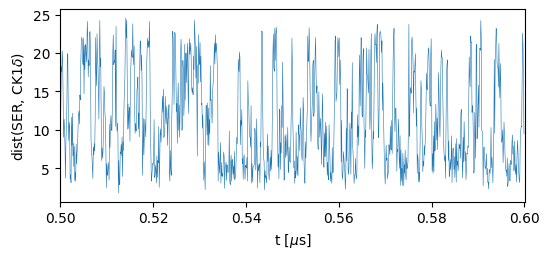

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2900.20it/s]


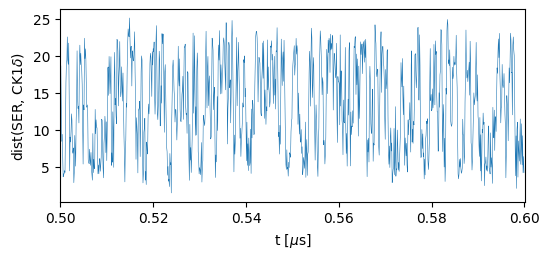

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2761.23it/s]


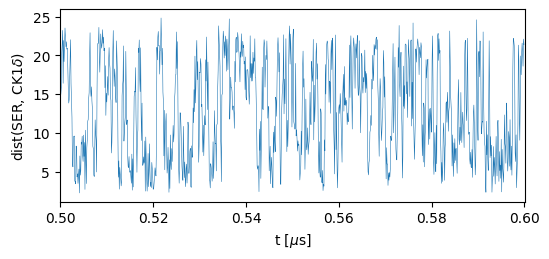

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2738.36it/s]


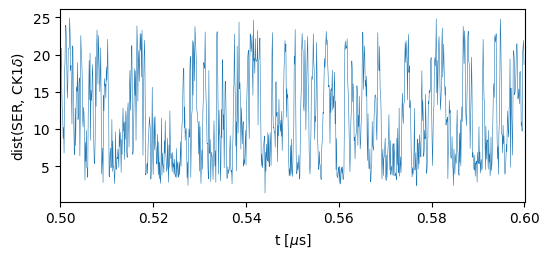

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2912.87it/s]


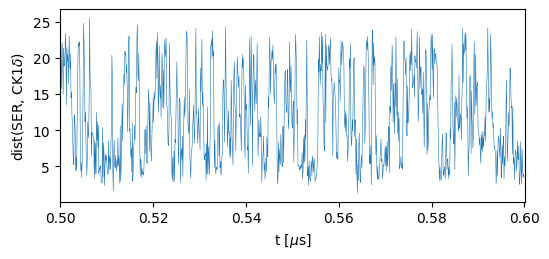

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2888.72it/s]


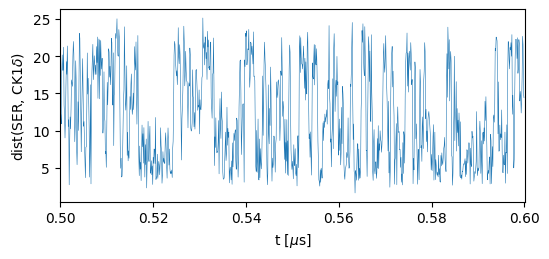

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2968.80it/s]


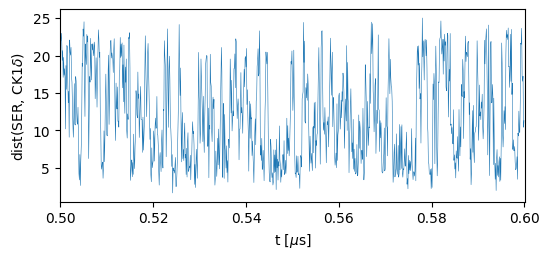

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2657.54it/s]


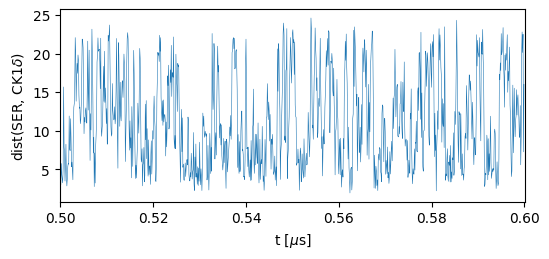

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2511.92it/s]


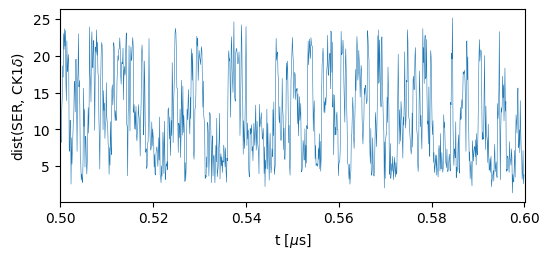

100%|█████████████████████████████████████████████████████████████| 12000/12000 [00:04<00:00, 2898.65it/s]


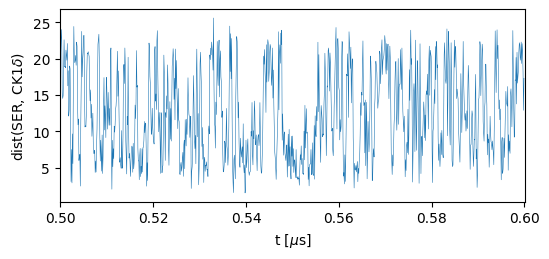

In [8]:
for s in range(1,11):
    d = hpau.create_distance_file(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_dump.gsd', 
                                         id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    tmp = hpau.create_distance_file(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_dump.gsd', 
                                         id1=[445+92,445+94,445+120,445+152,445+283], id2=[i for i in range(154)], mean1=True, therm=0)
    d = np.append(d, tmp, axis=1)
    np.savetxt(path_fix+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:42<00:00, 4654.27it/s]


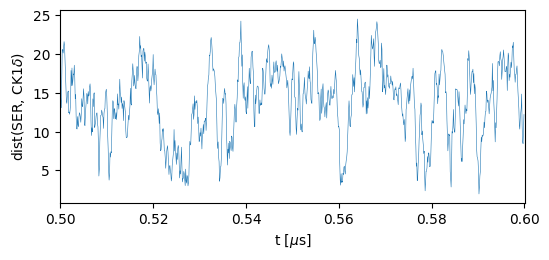

100%|█████████████████████████████████████████████████████████| 200000/200000 [01:00<00:00, 3325.35it/s]


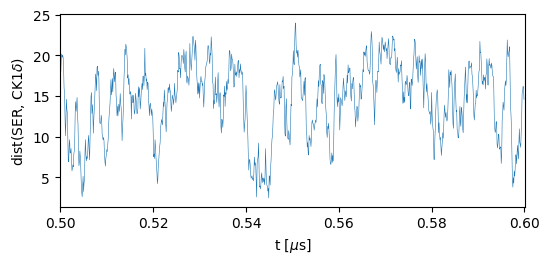

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:39<00:00, 5035.83it/s]


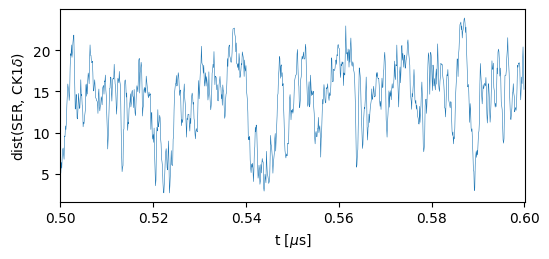

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:41<00:00, 4788.33it/s]


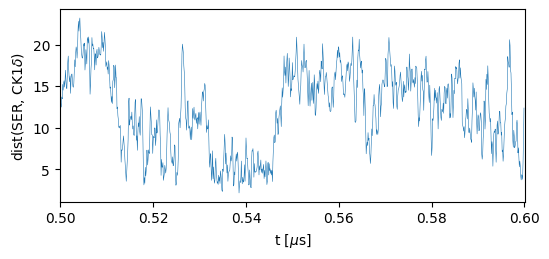

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:39<00:00, 5019.90it/s]


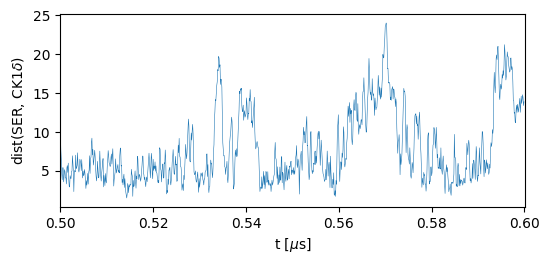

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:40<00:00, 4917.04it/s]


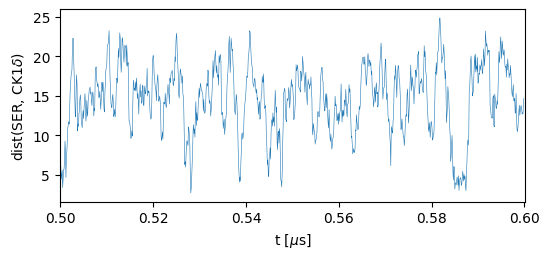

100%|█████████████████████████████████████████████████████████| 200000/200000 [01:00<00:00, 3280.36it/s]


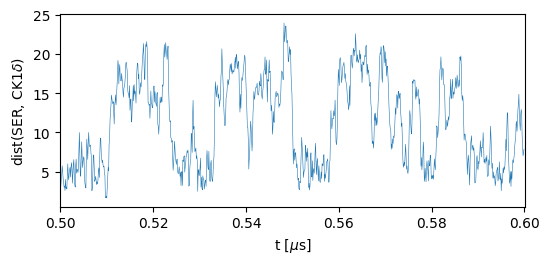

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:42<00:00, 4752.80it/s]


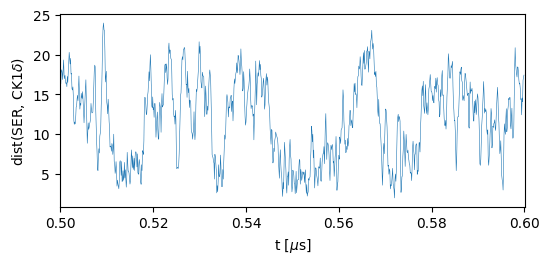

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:40<00:00, 4915.90it/s]


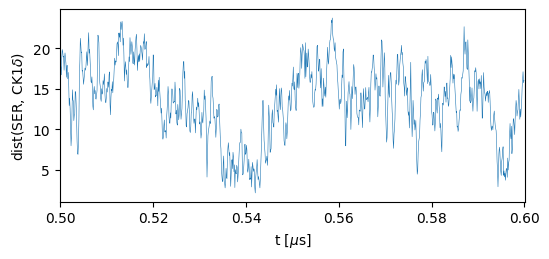

100%|█████████████████████████████████████████████████████████| 200000/200000 [00:38<00:00, 5193.38it/s]


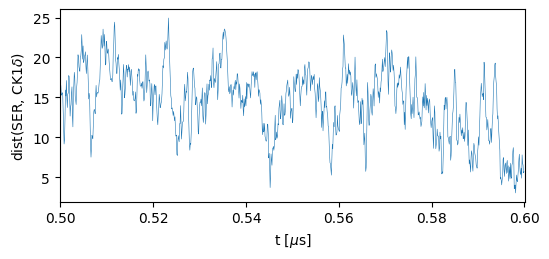

In [7]:
rdump = 5
rigid = 'rigid-'
dmu = 15
path_mc = f'/localscratch/zippoema/working_dir/tests/test_MC_kinetic/'
for s in range(11,21):
    d = hpau.create_distance_file(path_mc+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k_MCkin/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_MCkin_dump.gsd', 
                                     id1=[300,301,302], id2=[i for i in range(154)], mean1=True, therm=0)
    np.savetxt(path_mc+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k_MCkin/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_MCkin_dist.txt', d)
    hpapl.plot_dist(d,part_id=5,start=5000,end=6000)